In [147]:
%env CC=gcc-11
%env CXX=g++-11

env: CC=gcc-11
env: CXX=g++-11


## Intorduction

As in data analysis we first need to load the data and perform all the normalization and optimizations. The normalized data after all will be passed through PCA just to get only relavent features in the data. 

So let's start with data loading:

##### Normal data

In [2]:
import pandas

DATA = pandas.read_csv('../../../rnn/merged.csv')
DATA

,Counter(/clock),Mean_Consecutive(/clock),Counter(/host_diagnostic),Mean_Consecutive(/host_diagnostic),Counter(/joint_states),Mean_Consecutive(/joint_states),Counter(/kinect2/qhd/camera_info),Mean_Consecutive(/kinect2/qhd/camera_info),Counter(/kinect2/qhd/image_color/compressed),Mean_Consecutive(/kinect2/qhd/image_color/compressed),...,Threads(/move_base),MeanLoadCPU(/move_base),matansar(MinCPU0),matansar(StdCPU0),matansar(MinCPU1),matansar(StdCPU1),matansar(MinCPU2),matansar(StdCPU2),matansar(MinCPU3),matansar(StdCPU3)
0,416,0.001114,2,0.580318,35,0.021638,6,0.026784,3,0.045631,...,11.0,17.000000,9.220000e+18,9.220000e+18,9.220000e+18,9.220000e+18,9.220000e+18,9.220000e+18,9.220000e+18,9.220000e+18
1,920,0.001083,2,0.561588,46,0.021695,14,0.065842,10,0.105388,...,11.0,19.445455,9.220000e+18,9.220000e+18,9.220000e+18,9.220000e+18,9.220000e+18,9.220000e+18,9.220000e+18,9.220000e+18
2,905,0.001100,2,0.555192,45,0.022060,12,0.080915,9,0.112184,...,11.0,17.590000,9.220000e+18,9.220000e+18,9.220000e+18,9.220000e+18,9.220000e+18,9.220000e+18,9.220000e+18,9.220000e+18
3,934,0.001067,2,0.512376,47,0.021101,10,0.083380,9,0.105279,...,11.0,18.133333,9.220000e+18,9.220000e+18,9.220000e+18,9.220000e+18,9.220000e+18,9.220000e+18,9.220000e+18,9.220000e+18
4,941,0.001061,2,0.525791,47,0.021254,14,0.065183,10,0.105074,...,11.0,17.009091,9.220000e+18,9.220000e+18,9.220000e+18,9.220000e+18,9.220000e+18,9.220000e+18,9.220000e+18,9.220000e+18
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17870,980,0.001020,2,0.510422,49,0.019995,12,0.073625,10,0.103233,...,11.0,9.681818,9.220000e+18,9.220000e+18,9.220000e+18,9.220000e+18,9.220000e+18,9.220000e+18,9.220000e+18,9.220000e+18
17871,929,0.001076,2,0.553366,46,0.021433,14,0.073147,9,0.106950,...,11.0,9.666667,9.220000e+18,9.220000e+18,9.220000e+18,9.220000e+18,9.220000e+18,9.220000e+18,9.220000e+18,9.220000e+18
17872,953,0.001047,2,0.523317,48,0.020427,12,0.057224,10,0.104793,...,11.0,8.754546,9.220000e+18,9.220000e+18,9.220000e+18,9.220000e+18,9.220000e+18,9.220000e+18,9.220000e+18,9.220000e+18
17873,912,0.001091,2,0.561547,46,0.021688,12,0.079705,9,0.111040,...,11.0,8.610000,9.220000e+18,9.220000e+18,9.220000e+18,9.220000e+18,9.220000e+18,9.220000e+18,9.220000e+18,9.220000e+18


##### Anomaly data

In [3]:
ANOMALY_DATA = pandas.read_csv('../../../rnn/merged_test.csv')
ANOMALY_DATA

,Counter(/clock),Mean_Consecutive(/clock),Counter(/host_diagnostic),Mean_Consecutive(/host_diagnostic),Counter(/joint_states),Mean_Consecutive(/joint_states),Counter(/kinect2/parameter_descriptions),Counter(/kinect2/parameter_updates),Counter(/kinect2/qhd/camera_info),Mean_Consecutive(/kinect2/qhd/camera_info),...,Threads(/move_base),MeanLoadCPU(/move_base),matansar(MinCPU0),matansar(StdCPU0),matansar(MinCPU1),matansar(StdCPU1),matansar(MinCPU2),matansar(StdCPU2),matansar(MinCPU3),matansar(StdCPU3)
0,469,0.001026,2,0.518104,34,0.020897,1,1,6,0.050149,...,11.0,11.820000,9.220000e+18,9.220000e+18,9.220000e+18,9.220000e+18,9.220000e+18,9.220000e+18,9.220000e+18,9.220000e+18
1,897,0.001115,2,0.550576,45,0.022322,0,0,12,0.071620,...,11.0,13.577778,9.220000e+18,9.220000e+18,9.220000e+18,9.220000e+18,9.220000e+18,9.220000e+18,9.220000e+18,9.220000e+18
2,865,0.001155,2,0.565974,43,0.023229,0,0,12,0.059923,...,11.0,11.910000,9.220000e+18,9.220000e+18,9.220000e+18,9.220000e+18,9.220000e+18,9.220000e+18,9.220000e+18,9.220000e+18
3,946,0.001051,2,0.530423,48,0.021028,0,0,14,0.073898,...,11.0,11.945455,9.220000e+18,9.220000e+18,9.220000e+18,9.220000e+18,9.220000e+18,9.220000e+18,9.220000e+18,9.220000e+18
4,949,0.001044,2,0.520119,48,0.021061,0,0,14,0.064801,...,11.0,11.488889,9.220000e+18,9.220000e+18,9.220000e+18,9.220000e+18,9.220000e+18,9.220000e+18,9.220000e+18,9.220000e+18
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1023,822,0.001080,1,0.000000,40,0.021743,0,0,12,0.068342,...,11.0,12.580000,9.220000e+18,9.220000e+18,9.220000e+18,9.220000e+18,9.220000e+18,9.220000e+18,9.220000e+18,9.220000e+18
1024,1027,0.000952,2,0.473058,51,0.019016,0,0,12,0.069623,...,11.0,15.580000,9.220000e+18,9.220000e+18,9.220000e+18,9.220000e+18,9.220000e+18,9.220000e+18,9.220000e+18,9.220000e+18
1025,917,0.001091,2,0.539508,46,0.021793,0,0,14,0.067429,...,11.0,17.455556,9.220000e+18,9.220000e+18,9.220000e+18,9.220000e+18,9.220000e+18,9.220000e+18,9.220000e+18,9.220000e+18
1026,841,0.001188,2,0.595000,42,0.023028,0,0,12,0.072452,...,11.0,15.320000,9.220000e+18,9.220000e+18,9.220000e+18,9.220000e+18,9.220000e+18,9.220000e+18,9.220000e+18,9.220000e+18


For normalization we choose `MinMaxScaler` with value range between $\left[1, -1\right]$

In [4]:
import matplotlib.pyplot as plt
from scipy.stats import beta
from scipy.stats import norm
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm
import os
from sklearn.decomposition import PCA
import datetime
from IPython.display import Image
import math

## Data processing

#### Data processing utils

In [257]:
scalers = {}

def normalize_data(original_data):
    """
    This function used for normalizing data, with MinMaxScaler.
    Each scaler saved in the external object for future use of de-transformation
    :param original_data: data from the file
    :return: normlized data in the same format as received
    """
    norm_data = original_data
    for i in original_data.columns:
        scaler = None
        if ('scaler_' + i) not in scalers:
            scaler = MinMaxScaler(feature_range=(-1, 1))
        else:
            scaler = scalers['scaler_' + i]
        s_s = scaler.fit_transform(norm_data[i].values.reshape(-1, 1))
        s_s = np.reshape(s_s, len(s_s))
        scalers['scaler_' + i] = scaler
        norm_data[i] = s_s
    return norm_data

def std_normalize_data(data):
    """
    This function used for normalizing data, with StandardScaler.
    Each scaler saved in the external object for future use of de-transformation
    :param original_data: data from the file
    :return: normlized data in the same format as received
    """
    norm_data = data
    for i in data.columns:
        scaler = None
        if ('scaler_' + i) not in scalers:
            scaler = MinMaxScaler(feature_range=(0, 1))
        else:
            scaler = scalers['scaler_' + i]
        s_s = scaler.fit_transform(norm_data[i].values.reshape(-1, 1))
        s_s = np.reshape(s_s, len(s_s))
        scalers['scaler_' + i] = scaler
        norm_data[i] = s_s
    return norm_data

def unnormalize_data(columns, reconstructed_data):
    """
    This function is normalization inverse function.
    :param columns: orinal columns names, used for taking correct scaler that was saved while normalization
    :param reconstructed_data: normalized data
    :return: unnormalized data 
    """
    restored_data = []
    for (i, name) in enumerate(columns):
        restored_data.append(np.array(scalers['scaler_' + name].inverse_transform(reconstructed_data[:,i].reshape(-1, 1))).flatten())
    return np.array(restored_data)

def draw_from_GMM(mus, sigmas, thetas, numOfDraws = 1):
    """
    This function draws samples based on mu, sigma and theta of Gaussian Mixture Model
    :param mus: list of mus
    :param sigmas: list of sigmas
    :param thetas: list of thetas
    :param numOfDraws: number of draws from distribution
    :return: list of samples and list of lists of samples
    """
    gmm_res = []
    gaussians = []
    for j in range(len(thetas[0])):
        gaussians.append([])
    for i in tqdm(range(len(mus))):
        mixture_idx = np.random.choice(len(thetas[i]), size=1, replace=True, p=thetas[i])[0]
        samples = np.random.normal(mus[i,mixture_idx], sigmas[i,mixture_idx], size=numOfDraws)
        sample_index = np.random.choice(len(samples), size=1, replace=True)[0]
        gmm_res.append(samples[sample_index]) 
        gaussians[mixture_idx].append(samples[sample_index])
    return gmm_res, gaussians

##### Choosing common columns

While looking on the data we saw that there are small difference in the columns of anomaly and normal data, so we tried to find common columns.

In [6]:
norm_data, columns = normalize_data(DATA.copy()).values, list(DATA.columns.values)

columns = DATA.columns
anomaly_columns = ANOMALY_DATA.columns
common_columns = np.intersect1d(columns, anomaly_columns)
common_columns = [x for _, x in sorted(zip(columns, common_columns), key=lambda pair: pair[0])]
anomaly_norm_data = normalize_data(ANOMALY_DATA.copy())[common_columns].values
print(anomaly_norm_data.shape)

(1028, 71)


#### Running PCA and taking only two columns

In [7]:
norm_data = normalize_data(DATA[common_columns].copy())
print('Original dataset shape:', norm_data.shape)
pca = PCA(n_components=0.9)
new_data = pca.fit_transform(norm_data)
n_pcs = pca.n_components_
most_important = [[np.abs(pca.components_[i]).argmax(), np.abs(pca.components_[i]).max()] for i in range(n_pcs)]
most_important = sorted(most_important , key=lambda a_entry: -a_entry[1])
most_important_data_fragment = pandas.DataFrame(most_important, columns=['Index of column', 'PCA coefficient'])
most_important_data_fragment

Original dataset shape: (17875, 71)


,Index of column,PCA coefficient
0,15,0.807374
1,30,0.769483
2,45,0.741393
3,59,0.718888
4,12,0.691078
5,23,0.656097
6,52,0.642728
7,54,0.629880
8,30,0.625120
9,16,0.555479


In [8]:
initial_feature_names = DATA.columns
most_important_column_names = [initial_feature_names[most_important[i][0]] for i in range(n_pcs)]
most_important_column_names_df = pandas.DataFrame(most_important_column_names, columns=['Column name'])
most_important_column_names_df

,Column name
0,Mean_Consecutive(/mobile_base_controller/odom)
1,Counter(/move_base/local_costmap/costmap)
2,Mean_Consecutive(/pan_tilt_trajectory_controll...
3,Threads(/twist_mux)
4,Counter(/mobile_base_controller/cmd_vel)
5,Mean_Consecutive(/move_base/TebLocalPlannerROS...
6,Counter(/scan)
7,Counter(/tf)
8,Counter(/move_base/local_costmap/costmap)
9,Counter(/move_base/NavfnROS/plan)


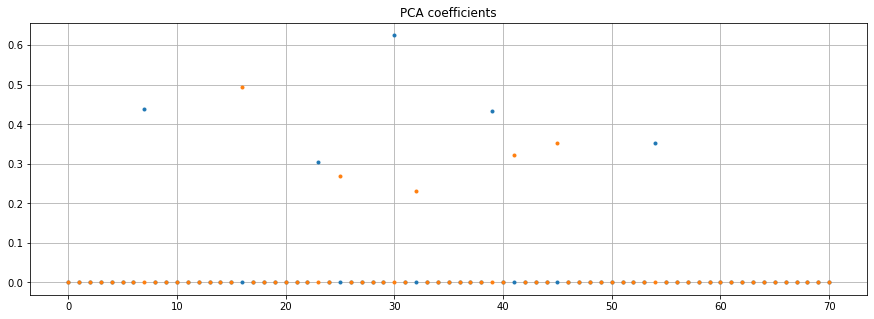

In [9]:
important_pca_comp = pca.components_[:2, :]
important_pca_comp = np.where(abs(important_pca_comp) <= 0.2, 0, important_pca_comp)
fig, axs = plt.subplots(1, figsize=(15, 5))
axs.plot(abs(important_pca_comp.T), ".")
axs.set_title('PCA coefficients')
plt.grid()
plt.show()
plt.close()

As the result of filtering we got only 10 points which mean that we have only 10 features of the original data will play major role in the linear transformation on the data we perform next.

##### Building linear combinations from important PCA components and original normilized data

So we took the list of components from the above plot and we multiply them by original and anomly normalized data as we show next: 

$$x = [x_1, x_2,...,x_{73}]\\$$
$$a = [0,0,0,..,a_n,0,..,a_k,0,...a_m,0...]\\\\
\tilde{y} = x \cdot a$$

(17875, 2)
(1028, 2)


Text(0.5, 1.0, 'Lineary transformed data')

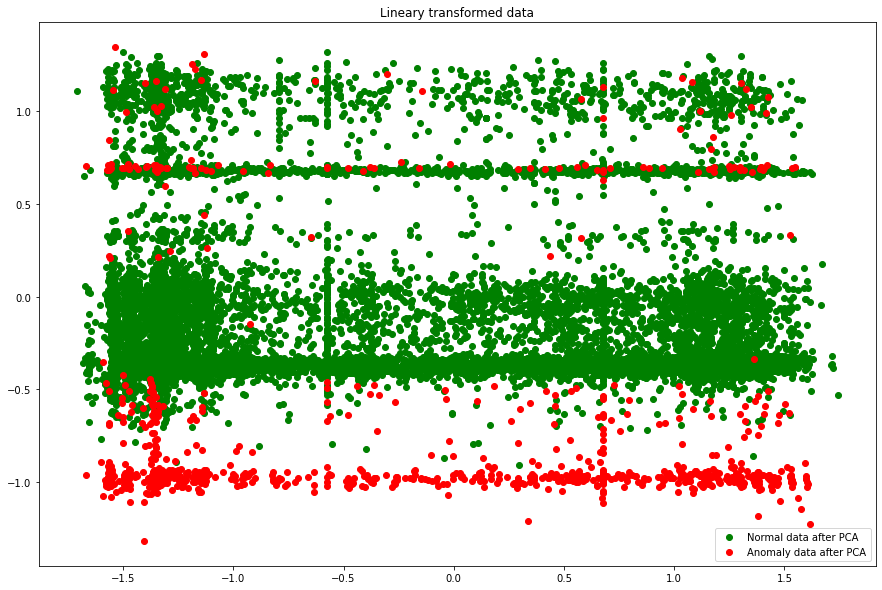

In [10]:
fig, axs = plt.subplots(1, figsize=(15, 10))
normal_pca_data = important_pca_comp.dot(norm_data.T).T
anomaly_pca_data = important_pca_comp.dot(anomaly_norm_data.T).T
print(normal_pca_data.shape)
print(anomaly_pca_data.shape)
axs.scatter(normal_pca_data[:,0], normal_pca_data[:,1], color="g", label="Normal data after PCA")
axs.scatter(anomaly_pca_data[:,0], anomaly_pca_data[:,1], color="r", label="Anomaly data after PCA")
axs.legend()
axs.set_title('Lineary transformed data')

In [11]:
normal_pca_data_df = pandas.DataFrame(normal_pca_data, columns=['y1', 'y2'])
normal_pca_data_df

,y1,y2
0,0.675685,-0.034512
1,1.435038,-0.259839
2,0.675685,0.040605
3,1.081021,-0.075067
4,1.416248,-0.317953
...,...,...
17870,0.641428,-0.347562
17871,0.953130,-0.399134
17872,1.397696,-0.365708
17873,1.177926,-0.341730


##### PCA Results plot 

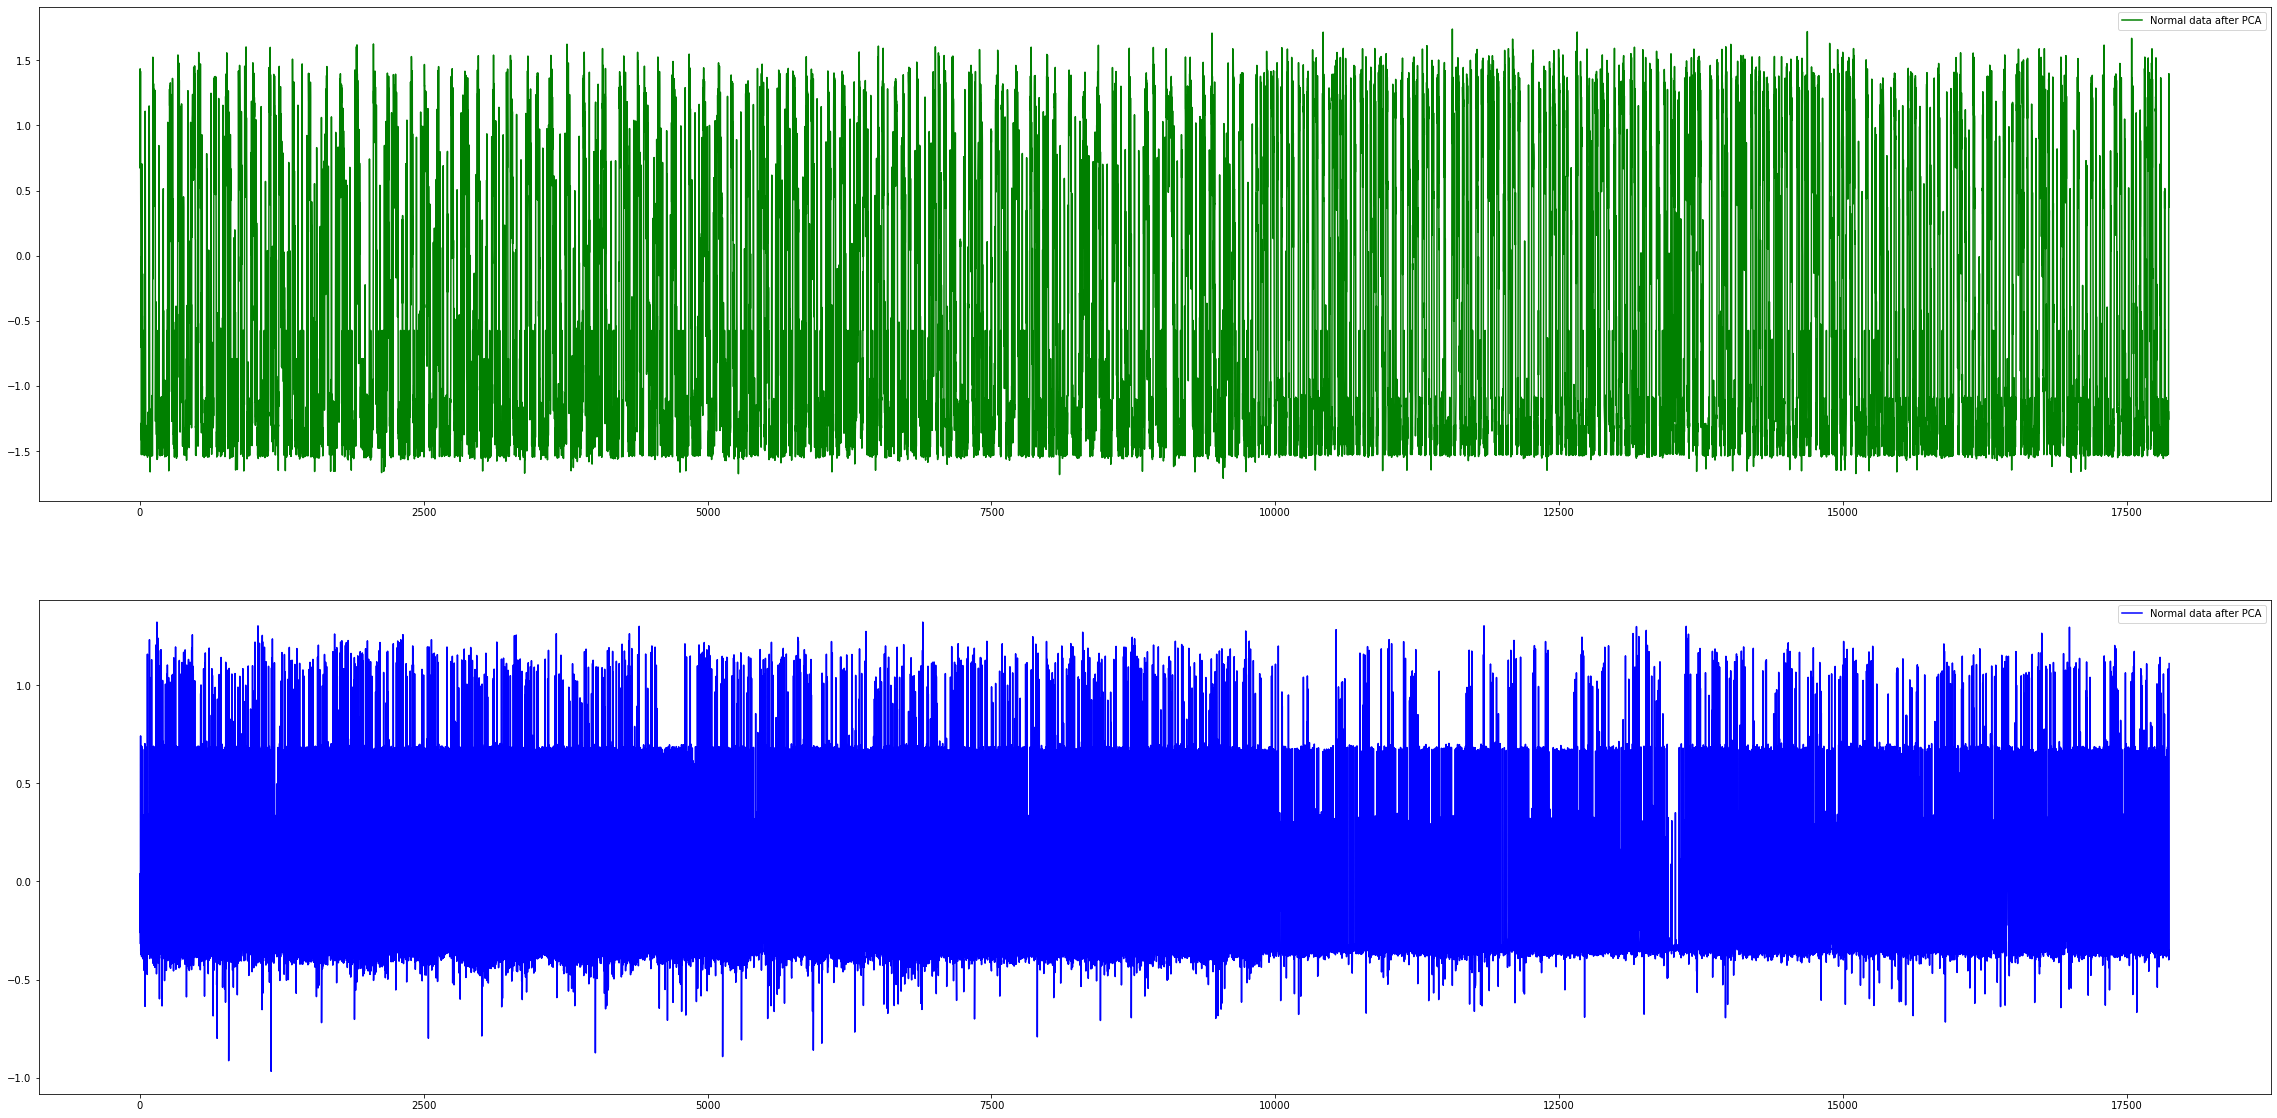

In [12]:
fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(40, 20), squeeze=False)
axs[0][0].plot(range(len(normal_pca_data[:,0])), normal_pca_data[:,0], color="g", label="Normal data after PCA")
axs[1][0].plot(range(len(normal_pca_data[:,1])), normal_pca_data[:,1], color="b", label="Normal data after PCA")
axs[0][0].legend()
axs[1][0].legend()

Just to understand behaviour of the data we decided to plot histogram

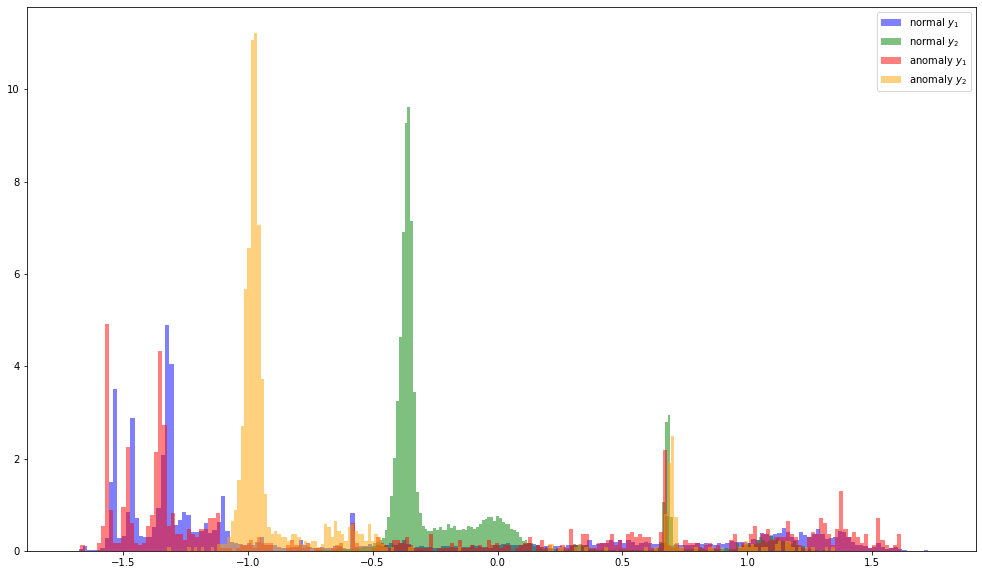

In [170]:
fig, axs = plt.subplots(1, figsize=(17, 10))
n, bins, patches = axs.hist(list(normal_pca_data[:, 0]), 200, facecolor='b', alpha=0.5, density=True, stacked=True, label="normal $y_1$")
n, bins, patches = axs.hist(list(normal_pca_data[:, 1]), 200, facecolor='g', alpha=0.5, density=True, stacked=True, label="normal $y_2$")
n, bins, patches = axs.hist(list(anomaly_pca_data[:, 0]), 200, facecolor='r', alpha=0.5, density=True, stacked=True, label="anomaly $y_1$")
n, bins, patches = axs.hist(list(anomaly_pca_data[:, 1]), 200, facecolor='orange', alpha=0.5, density=True, stacked=True, label="anomaly $y_2$")
axs.legend()

To see the results more clear we will normilize the data again to be in range between 0 and 1

## Model

Density estimation
DP-GMM or HDP



In [14]:
import pystan

In [223]:
GMM_MODEL = """
data {
    int<lower=0> N;            // Number of measurements
    vector[N] y;                 // Data
    
    int<lower=1> k;// Number of Gaussians

    real<lower=0> mu_loc_prior;
    real<lower=0> mu_shape_prior;
    real<lower=0> sigma_loc_prior;
    real<lower=0> sigma_shape_prior;

    real<lower=0> theta_loc_prior;
    real<lower=0> theta_scale_prior;
}
parameters {
    ordered[k] mu;
    real<lower=0> sigma[k];
    simplex[k] theta;
}
model {
    real ll[k];
    sigma ~ normal(sigma_loc_prior, sigma_shape_prior);
    mu ~ normal(mu_loc_prior, mu_shape_prior);
    theta ~ beta(theta_loc_prior, theta_scale_prior);
    
    for (n in 1:N) {
        for (i in 1:k) {
            ll[i] = log(theta[i]) + normal_lpdf(y[n] | mu[i], sigma[i]);
        }
        target += log_sum_exp(ll);
    }       
}
"""

In [224]:
model = pystan.StanModel(model_code=GMM_MODEL, verbose=False, extra_compile_args=["-w"])

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_c96ff13f2c78246360a2ede4a660feb0 NOW.


##### Model testing

For testing our model we will simulate the data of the mixture model with 3 Gaussians

In [230]:
def model_test():
    pi = [0.2, 0.7, 0.1]
    gen_mus = [-1.6, 0, 1.5]
    gen_sig = [0.1, 0.7, 0.1]
    gen_res = []
    gaussians = [[], [], []]
    # Generating data
    for i in range(2000):
        mixture_idx = np.random.choice(len(pi), size=1, replace=True, p=pi)[0]
        sample = np.random.normal(gen_mus[mixture_idx], gen_sig[mixture_idx], size=1)[0]
        gen_res.append(sample) 
        gaussians[mixture_idx].append(sample)
    fig, axs = plt.subplots(1, figsize=(17, 7))
    colors = ['r', 'g', 'b']
    for i in range(len(pi)):
        n, norm_bins1, patches = axs.hist(gaussians[i], 200, facecolor=colors[i], alpha=0.5, density=True, stacked=True, label="gaussian " + str(i + 1))
    axs.legend()
    axs.set_title('Original')
    
    # Running model
    mu_loc_prior = 0;
    mu_shape_prior = 2;
    sigma_loc_prior = 0;
    sigma_shape_prior = 2;
    theta_loc_prior = 5;
    theta_scale_prior = 5;

    st_data= {
        'N':len(gen_res),
        'y':gen_res,
        'k': 3,
        'mu_loc_prior': mu_loc_prior,
        'mu_shape_prior': mu_shape_prior,
        'sigma_loc_prior': sigma_loc_prior,
        'sigma_shape_prior': sigma_shape_prior,
        'theta_loc_prior': theta_loc_prior,
        'theta_scale_prior': theta_scale_prior
    }
    fit = model.sampling(data=st_data, iter=1000, verbose=True, n_jobs=-1)
    print(fit)
    
    # Sampling
    samples = fit.extract(permuted=True)
    mu = samples['mu']
    sigma = samples['sigma']
    theta = samples['theta']
    print(np.mean(mu, axis=0))
    print(np.mean(sigma, axis=0))
    print(np.mean(theta, axis=0))
    simulations, gaussians = draw_from_GMM(mu, sigma, theta, 1000)
    fig, axs = plt.subplots(1, figsize=(17, 7))
    
    # Ploting results
    for i in range(len(gaussians)):
        n, norm_bins, patches = axs.hist(gaussians[i], 200, facecolor=colors[i], alpha=0.5, density=True, stacked=True, label="gaussian " + str(i + 1))
    axs.legend()
    axs.set_title('Sampled')

Inference for Stan model: anon_model_c96ff13f2c78246360a2ede4a660feb0.
4 chains, each with iter=1000; warmup=500; thin=1; 
post-warmup draws per chain=500, total post-warmup draws=2000.

           mean se_mean     sd   2.5%     25%    50%    75%  97.5%  n_eff   Rhat
mu[1]     -1.61  9.5e-5 5.7e-3  -1.62   -1.61  -1.61   -1.6  -1.59   3597    1.0
mu[2]    5.4e-3  5.5e-4   0.02  -0.04 -8.4e-3 5.5e-3   0.02   0.05   1387    1.0
mu[3]       1.5  2.0e-4 9.0e-3   1.48     1.5    1.5   1.51   1.52   2074    1.0
sigma[1]    0.1  8.8e-5 4.5e-3   0.09    0.09    0.1    0.1   0.11   2654    1.0
sigma[2]   0.69  3.9e-4   0.02   0.65    0.68   0.69    0.7   0.72   1927    1.0
sigma[3]    0.1  2.0e-4 8.4e-3   0.08    0.09    0.1    0.1   0.12   1756    1.0
theta[1]    0.2  2.0e-4 9.7e-3   0.18    0.19    0.2   0.21   0.22   2326    1.0
theta[2]    0.7  2.8e-4   0.01   0.67    0.69    0.7    0.7   0.72   1836    1.0
theta[3]    0.1  1.9e-4 8.1e-3   0.09     0.1    0.1   0.11   0.12   1802    1.0
lp_

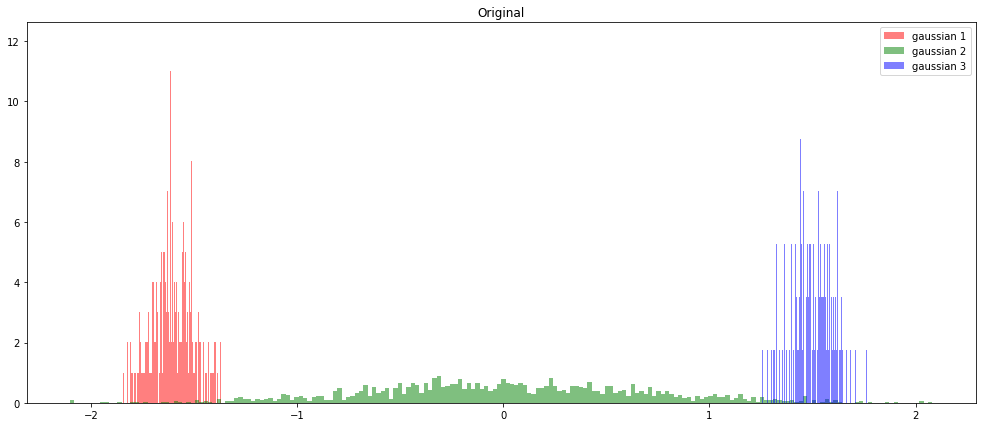

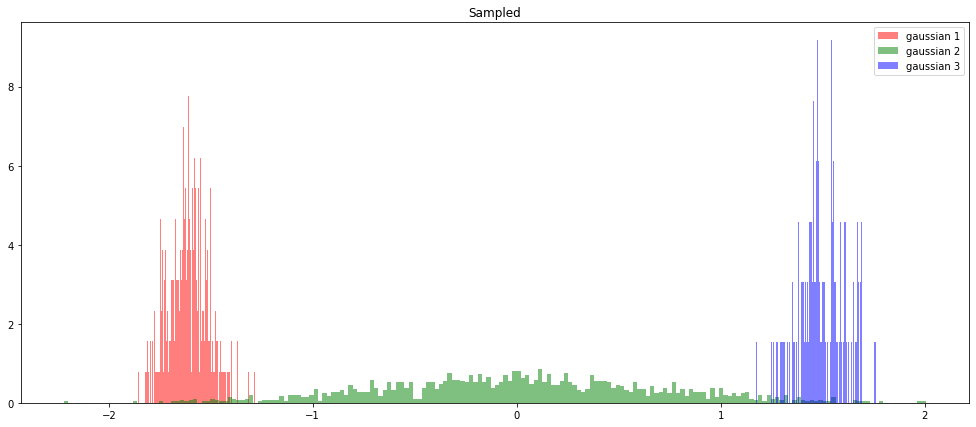

In [231]:
model_test()

Now after we saw that the model is working well with generated data lets try to run it on real one

##### Real data run

We will take only one dimension of our two dimensional dataset and try the model on it

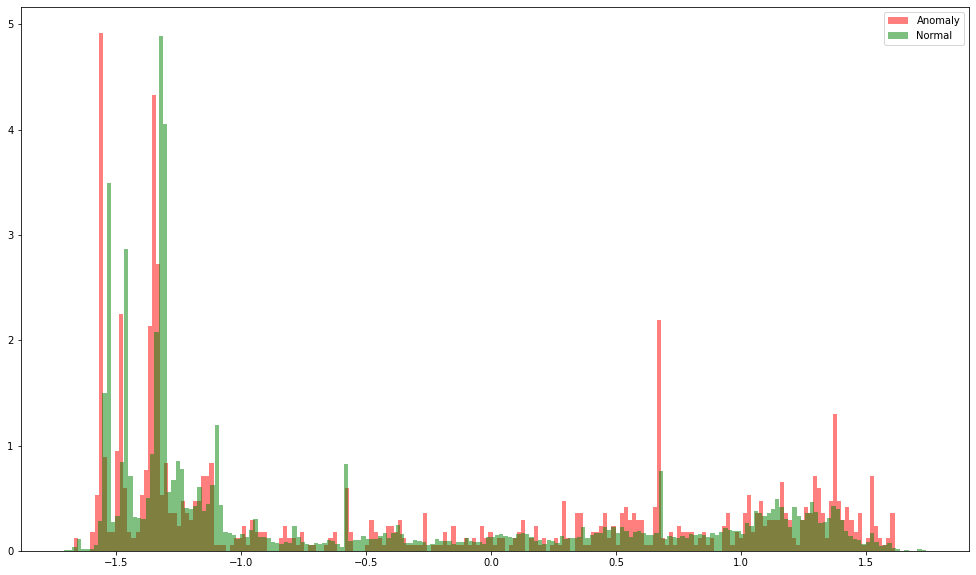

In [232]:
stan_normal_data = normal_pca_data
stan_anomaly_data = anomaly_pca_data
fig, axs = plt.subplots(1, figsize=(17, 10))
n, anomaly_bins, patches = axs.hist(stan_anomaly_data[:,0], 200, facecolor='r', alpha=0.5, density=True, stacked=True, label="Anomaly")
n, norm_bins, patches = axs.hist(stan_normal_data[:,0], 200, facecolor='g', alpha=0.5, density=True, stacked=True, label="Normal")
axs.legend()

In [235]:
mu_loc_prior = 0;
mu_shape_prior = 2;
sigma_loc_prior = 0.1;
sigma_shape_prior = 2;
theta_loc_prior = 5;
theta_scale_prior = 5;

st_data= {
    'N':stan_normal_data[:].shape[0],
    'y':stan_normal_data[:,0],
    'k': 3,
    'mu_loc_prior': mu_loc_prior,
    'mu_shape_prior': mu_shape_prior,
    'sigma_loc_prior': sigma_loc_prior,
    'sigma_shape_prior': sigma_shape_prior,
    'theta_loc_prior': theta_loc_prior,
    'theta_scale_prior': theta_scale_prior
}
fit = model.sampling(data=st_data, iter=1000, verbose=True, n_jobs=-1)
print(fit)

Inference for Stan model: anon_model_c96ff13f2c78246360a2ede4a660feb0.
4 chains, each with iter=1000; warmup=500; thin=1; 
post-warmup draws per chain=500, total post-warmup draws=2000.

           mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
mu[1]     -1.44    0.07   0.09  -1.53  -1.53  -1.44  -1.35  -1.34      2  86.84
mu[2]     -0.63    0.48   0.69  -1.32  -1.31  -0.64   0.06   0.08      2  67.81
mu[3]      0.85    0.25   0.36   0.47   0.49   0.85   1.21   1.22      2  46.94
sigma[1]   0.07    0.05   0.07 7.0e-3 7.4e-3   0.07   0.14   0.14      2  81.11
sigma[2]   0.41     0.2   0.28   0.13   0.13    0.4    0.7   0.71      2   44.1
sigma[3]   0.47    0.21   0.29   0.17   0.18   0.47   0.76   0.77      2  52.01
theta[1]   0.31    0.17   0.24   0.07   0.08   0.31   0.55   0.55      2  76.87
theta[2]   0.39    0.07   0.09   0.29    0.3   0.39   0.48   0.49      2  21.99
theta[3]    0.3     0.1   0.14   0.15   0.16    0.3   0.44   0.45      2  38.46
lp__     -1.4

In [236]:
samples = fit.extract(permuted=True)
mu = samples['mu']
sigma = samples['sigma']
theta = samples['theta']
print(np.mean(mu, axis=0))
print(np.mean(sigma, axis=0))
print(np.mean(theta, axis=0))

[-1.43978491 -0.62797397  0.84789131]
[0.07315742 0.41203892 0.46923849]
[0.31089315 0.38870764 0.30039921]


In [262]:
def calc_lppd(mus, sigmas, thetas, y):
    ppd_res = 0
    lppds = []
    for n in tqdm(range(len(y))):
        ppd_res = 0
        for i in range(len(mus)):
            mixture_idx = np.random.choice(len(thetas[i]), size=1, replace=True, p=thetas[i])[0]
            ppd_res += thetas[i, mixture_idx] * norm.pdf(y[n], mus[i, mixture_idx], sigmas[i, mixture_idx])
        lppds.append(math.log(np.average(ppd_res))) 
        
    return lppds, np.sum(lppds)


100%|██████████| 2000/2000 [00:00<00:00, 12966.29it/s]


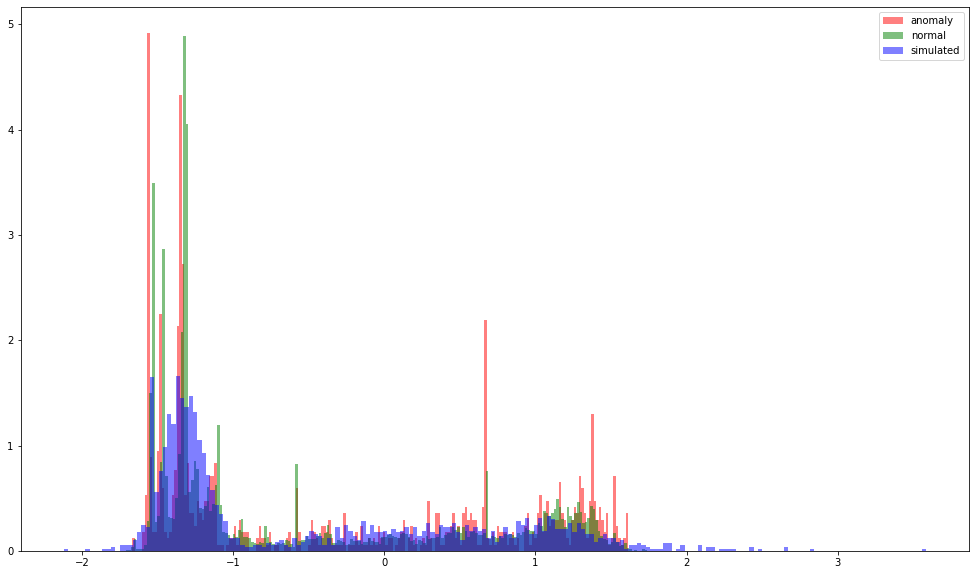

In [265]:
simulations, _ = draw_from_GMM(mu, sigma, theta, 1000)
fig, axs = plt.subplots(1, figsize=(17, 10))
n, bins, patches = axs.hist(stan_anomaly_data[:,0], 200, facecolor='r', alpha=0.5, density=True, stacked=True, label="anomaly")
n, bins, patches = axs.hist(stan_normal_data[:,0], 200, facecolor='g', alpha=0.5, density=True, stacked=True, label="normal")
n, bins, patches = axs.hist(simulations, 200, facecolor='b', alpha=0.5, density=True, stacked=True, label="simulated")
axs.legend()

In [266]:
lppds, lppd = calc_lppd(mu, sigma, theta, stan_anomaly_data[:,0])

100%|██████████| 1028/1028 [05:26<00:00,  3.15it/s]


5836.501993395465


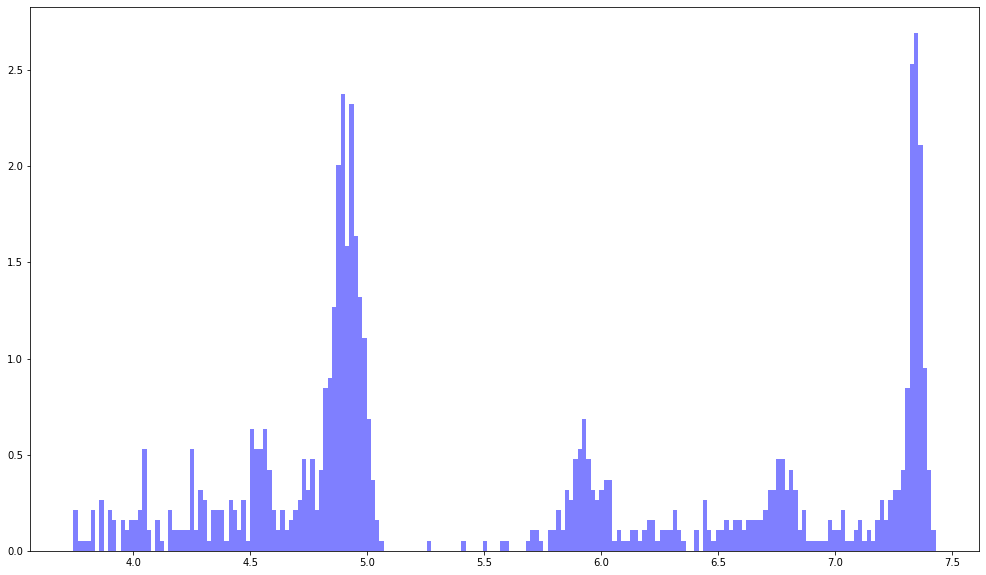

In [267]:
print(lppd)
fig, axs = plt.subplots(1, figsize=(17, 10))
n, bins, patches = axs.hist(lppds, 200, facecolor='b', alpha=0.5, density=True, stacked=True, label="simulated $y_1$")

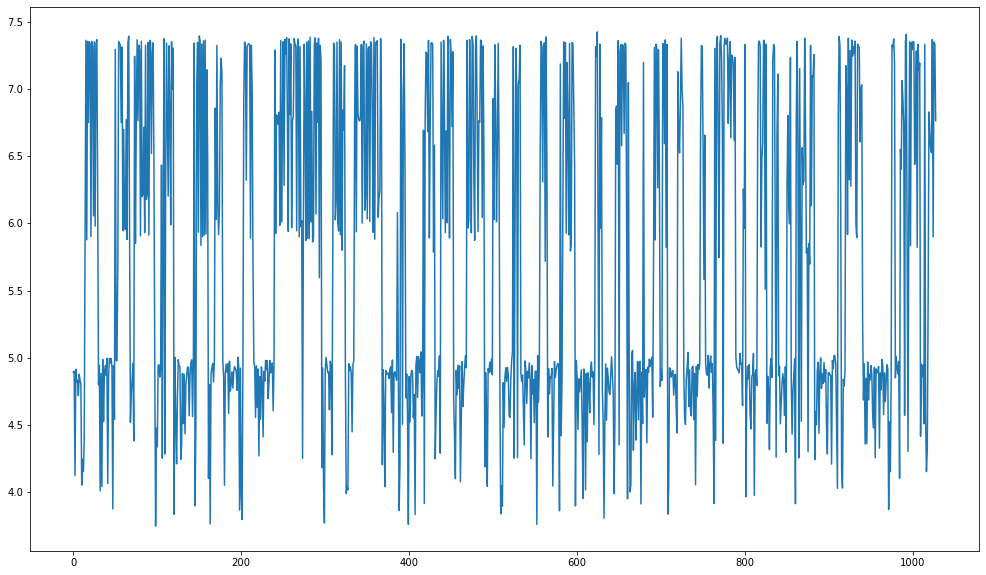

In [269]:
fig, axs = plt.subplots(1, figsize=(17, 10))
axs.plot(range(len(lppds)), lppds)


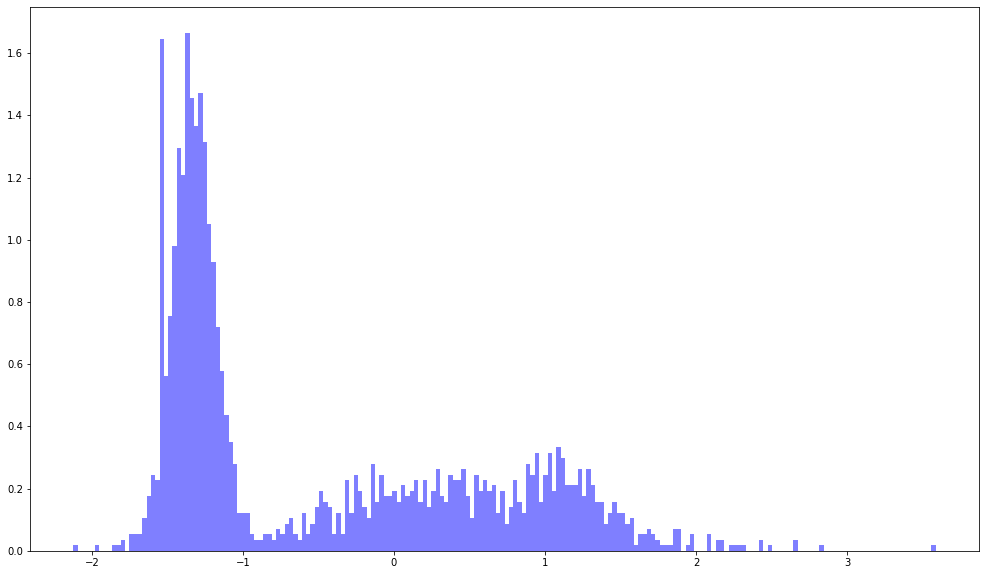

In [268]:
fig, axs = plt.subplots(1, figsize=(17, 10))
n, bins, patches = axs.hist(simulations, 200, facecolor='b', alpha=0.5, density=True, stacked=True, label="simulated $y_1$")


1. Simulate data
2. Laplace, student-t
3. Sound processing 

Try 2,3,4,5 Gaussians

Posterior sampling

2-d GMM

ARVIZ - https://arviz-devs.github.io/arviz/